In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

/Users/Hooman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
X_train = pd.read_csv('../data/interim/X-train.csv', usecols = ['question_text'])
y_train = pd.read_csv('../data/interim/y-train.csv', usecols = ['target'])
X_test = pd.read_csv('../data/interim/X-test.csv', usecols = ['question_text'])
y_test = pd.read_csv('../data/interim/y-test.csv', usecols = ['target'])

In [3]:
X_train.head()

,question_text
0,Can I get pregnant by dry humping?
1,Can I divade project in different git submodul...
2,How can I donate bone marrow in UAE?
3,What are the best books about negative thinking?
4,Why does Texas have high property taxes?


In [4]:
y_train.head()

,target
0,0
1,0
2,0
3,0
4,0


In [5]:
np.mean(y_test)

target    0.061863
dtype: float64

In [6]:
def calculate_accuracy(true_y, predicted_y):
    print('Accuracy: ', np.mean(predicted_y==true_y))

In [7]:
def plot_confusion_matrix(true_y, predicted_y):
    df = pd.DataFrame(data = {'y_Actual': true_y,
                              'y_Predicted': predicted_y
                             }, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                                   rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

In [8]:
def plot_roc(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [9]:
def calculate_precision_recall(model, X_test, y_test):
    disp = plot_precision_recall_curve(model, X_test, y_test)
    plt.show()
    return (disp.precision, disp.recall, disp.average_precision)

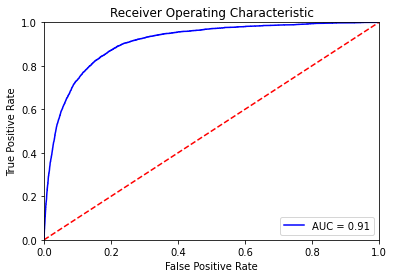

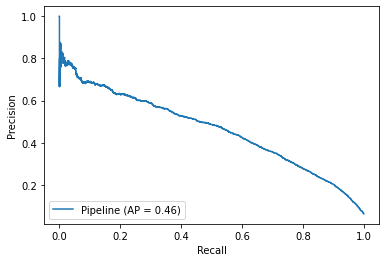

Accuracy:  0.9406792637736195


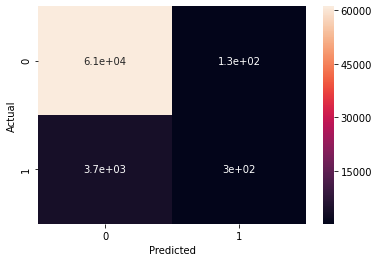

In [10]:
# Logistic regression
log_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log')),
])
log_clf.fit(X_train['question_text'], y_train['target'])

plot_roc(log_clf, X_test['question_text'], y_test['target'])

[precision, recall, average_precision] = calculate_precision_recall(log_clf, 
                                                                    X_test['question_text'], 
                                                                    y_test['target'])
log_predicted = log_clf.predict(X_test['question_text'])
calculate_accuracy(y_test['target'],log_predicted)
plot_confusion_matrix(y_test['target'],log_predicted)


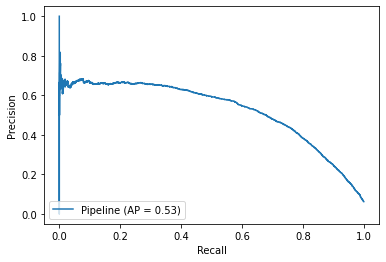

Accuracy:  0.9389948856154106


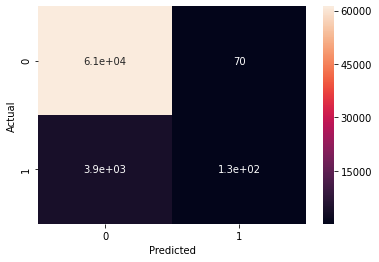

In [11]:
# SVM
svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge')),
])
svm_clf.fit(X_train['question_text'], y_train['target'])

#plot_roc(svm_clf, X_test['question_text'], y_test['target'])

[precision, recall, average_precision] = calculate_precision_recall(svm_clf, 
                                                                    X_test['question_text'], 
                                                                    y_test['target'])

svm_predicted = svm_clf.predict(X_test['question_text'])
calculate_accuracy(y_test['target'],svm_predicted)
plot_confusion_matrix(y_test['target'],svm_predicted)

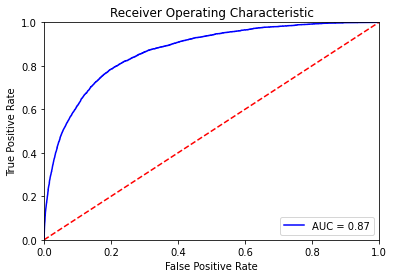

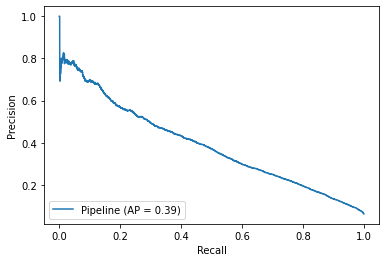

Accuracy:  0.9386733225124797


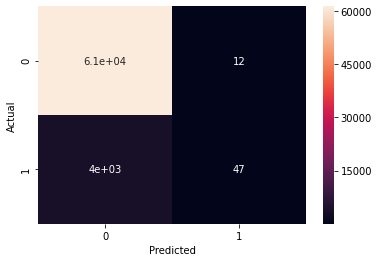

In [12]:
# Naive Bayes
naive_bayes_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
naive_bayes_clf.fit(X_train['question_text'], y_train['target'])

plot_roc(naive_bayes_clf, X_test['question_text'], y_test['target'])

[precision, recall, average_precision] = calculate_precision_recall(naive_bayes_clf, 
                                                                    X_test['question_text'], 
                                                                    y_test['target'])

naive_bayes_predicted = naive_bayes_clf.predict(X_test['question_text'])
calculate_accuracy(y_test['target'],naive_bayes_predicted)
plot_confusion_matrix(y_test['target'],naive_bayes_predicted)

In [13]:
from sklearn.base import BaseEstimator
class DummyClf(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [14]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClf()),
])

parameters = [
    {
        'vect__stop_words': ('english', None,),
        'vect__lowercase': (True, None,),
        'clf': [SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__penalty': ('l2', 'elasticnet', 'l1'),
        #'clf__max_iter': [50, 80],
        'clf__penalty': ('l1','l2','elasticnet'),
        'clf__alpha': (1e-3, 1e-4, 1e-5, 1e-6),
        'clf__tol': [1e-4],
        'clf__loss': ['hinge', 'log'],
    },
    {
        'vect__stop_words': ('english', None,),
        'vect__lowercase': (True, None,),
        'clf': [MultinomialNB()],
        'clf__alpha': (1e-3, 1e-4, 1e-5, 1e-6),
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, scoring='average_precision')

In [15]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
gscv.fit(X_train['question_text'], y_train['target'])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % gscv.best_score_)
print("Best parameters set:")
best_parameters = gscv.best_estimator_.get_params()
print(best_parameters['vect'])
print(best_parameters['tfidf'])
print(best_parameters['clf'])

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)],
  'clf__alpha': (0.001, 0.0001, 1e-05, 1e-06),
  'clf__loss': ['hinge', 'log'],
  'clf__penalty': ('l1', 'l2', 'elasticnet'),
  'clf__tol': [0.0001],
  'vect__lowercase': (True, None),
  'vect__stop_words': ('english', None)},
 {'clf': [MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)],
  'clf__alpha': (0.001, 0.0001, 1e-05, 1e-06),
  'vect__lowercase': (True, None),
  'vect__stop_words': ('english', None)}]
done in 1365.348s

Best score: 0.580
Best parameters set:
CountVector

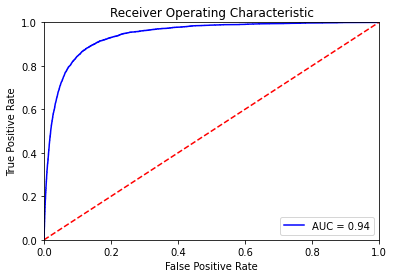

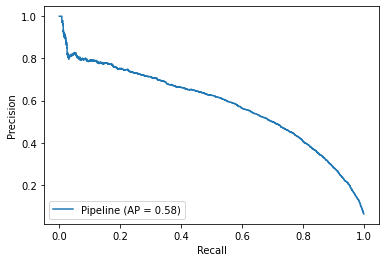

Accuracy:  0.9503567819189661


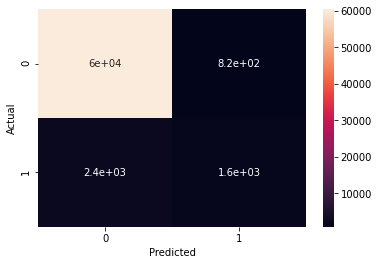

In [16]:
best_model  = gscv.best_estimator_
best_model.fit(X_train['question_text'], y_train['target'])

plot_roc(best_model, X_test['question_text'], y_test['target'])

[precision, recall, average_precision] = calculate_precision_recall(best_model, 
                                                                    X_test['question_text'], 
                                                                    y_test['target'])

best_model_predicted = best_model.predict(X_test['question_text'])
calculate_accuracy(y_test['target'], best_model_predicted)
plot_confusion_matrix(y_test['target'], best_model_predicted)

In [17]:
coefs = best_model.named_steps['clf'].coef_[0]
print(len(coefs))
print(sum(coefs>0))

72881
12123


In [18]:
pipe = Pipeline([('vect', gscv.best_estimator_['vect']),
                 ('tfidf', gscv.best_estimator_['tfidf'])]).fit(X_train['question_text'])

features = pipe['vect'].get_feature_names()
print(len(features))

72881


In [19]:
dfx = pd.DataFrame({'features':features, 'coef':coefs})
dfx.sort_values(by=['coef'], inplace=True)

In [22]:
dfx.head(10)

,features,coef
70818,what,-11.685747
31509,how,-4.742156
54500,regret,-3.801056
4888,amazon,-3.799389
10295,books,-3.662189
33474,inhabit,-3.603526
14996,comfortable,-3.443951
19076,describe,-3.394436
70889,which,-3.352829
50892,potential,-3.271474


In [23]:
dfx.tail(10)

,features,coef
38347,liberals,6.688490
33147,indians,6.706612
9742,blacks,6.778003
18745,democrats,6.796623
53589,rape,6.875030
26733,fuck,7.002789
43885,muslims,7.510687
12490,castration,9.878453
12487,castrate,10.316382
12488,castrated,11.833293
